In [1]:
# What version of Python do you have?
import sys
import os
import tensorflow.keras
import pandas as pd
import sklearn as sk
import tensorflow as tf
import numpy as np
import re
import mne
import pathlib
import openpyxl
from datetime import datetime
import pytz
import random
import os
from skimage.restoration import (denoise_wavelet, estimate_sigma)
from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, Sequential
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, multilabel_confusion_matrix, ConfusionMatrixDisplay, confusion_matrix, plot_confusion_matrix
from PIL import Image
%matplotlib inline

print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Tensor Flow Version: 2.6.0
Keras Version: 2.6.0

Python 3.7.11 (default, Jul 27 2021, 09:42:29) [MSC v.1916 64 bit (AMD64)]
Pandas 1.3.3
Scikit-Learn 0.24.2
GPU is available


In [2]:
os.path.abspath(os.sep)

'c:\\'

In [3]:
# os.chdir("E:\Database")
# os.getcwd()

In [4]:
os.getcwd()

'c:\\Users\\thoma\\Desktop\\speciale\\DeepLearning_Master\\models\\IncepResnetV2_only_sz_data'

In [5]:
os.getcwd()
external_hardisk_data_path = os.path.abspath(os.sep) + "E:\Database"

train_path = "../../../psd_dual_channel_10_patient/windows/train"

test_path = "../../../psd_dual_channel_10_patient/windows/test"

resnet152_input_shape = (224, 224)

inceptionV3_input_shape = (299, 299)

batch_size = 1

In [6]:
for f in os.listdir(train_path):
    print(f)

Interictal
Preictal_One
Preictal_Two
Seizure


In [7]:
from tensorflow.keras.applications import VGG16, ResNet152

In [8]:
labels = [item for item in os.listdir(train_path)]
labels

['Interictal', 'Preictal_One', 'Preictal_Two', 'Seizure']

In [9]:
def inspect_class_distribution():
    dist_list = []
    for i in os.listdir(train_path):
        classname = i
        number_of_png = str(len([x for x in os.listdir(train_path + "/" + i)]))
        dict = {classname, number_of_png}
        dist_list.append(dict)
    return dist_list

bla = inspect_class_distribution()

In [10]:
bla

[{'22559', 'Interictal'},
 {'8143', 'Preictal_One'},
 {'5216', 'Preictal_Two'},
 {'1061', 'Seizure'}]

In [11]:
inceptionResnet = ResNet152(
    weights='imagenet',
    include_top=False,
    input_shape = (224, 224, 3)
)

for layer in inceptionResnet.layers:
    layer.trainable = True

inceptionResnet.summary()

Model: "resnet152"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
__________________________________________________________________________________________

In [12]:
single_inc_model = Sequential()

single_inc_model.add(inceptionResnet)
single_inc_model.add(layers.Dense(1024, activation='relu'))
single_inc_model.add(layers.Dropout(0.5))
single_inc_model.add(layers.Flatten())
single_inc_model.add(layers.Dense(512, activation='relu'))
single_inc_model.add(layers.Dropout(0.5))
single_inc_model.add(layers.Dense(4, activation='softmax'))

In [13]:
single_inc_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152 (Functional)       (None, 7, 7, 2048)        58370944  
_________________________________________________________________
dense (Dense)                (None, 7, 7, 1024)        2098176   
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 1024)        0         
_________________________________________________________________
flatten (Flatten)            (None, 50176)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               25690624  
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 2

In [14]:
from tensorflow.keras.layers import Layer
# build model
model2 = Sequential()
model2.add(layers.Conv2D(32, 3, padding='same', activation='relu',input_shape=(299,299,3))) 
model2.add(layers.MaxPool2D()) 
model2.add(layers.Dropout(0.2))
model2.add(layers.Conv2D(64, 5, padding='same', activation='relu'))
model2.add(layers.MaxPool2D())
model2.add(layers.Dropout(0.4))
model2.add(layers.Flatten())
model2.add(layers.Dense(128, activation='relu'))
model2.add(layers.Dense(1, activation='sigmoid'))

In [15]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 299, 299, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 32)      0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 149, 149, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 149, 149, 64)      51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 74, 74, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 350464)           

In [16]:
from tensorflow.keras.applications.resnet import preprocess_input

In [17]:
generator = ImageDataGenerator(
 # rescale=1./255,
  validation_split=0.2,
  rescale=1.255
)

In [18]:
inception_train_gen = generator.flow_from_directory(
    train_path,
    batch_size=batch_size, 
    target_size=resnet152_input_shape, 
    shuffle=True,
   # class_mode="binary",
    subset="training")

Found 29585 images belonging to 4 classes.


In [19]:
inception_validation_gen = generator.flow_from_directory(
    train_path,
    batch_size=batch_size, 
    target_size=resnet152_input_shape, 
    shuffle=True,
 #   class_mode="binary",
    subset="validation")

Found 7394 images belonging to 4 classes.


In [20]:
inception_train_gen.classes

array([0, 0, 0, ..., 3, 3, 3])

In [21]:
class_weights = {0: 0.4098031827651935,
                1: 1.1353002578902125,
                2: 1.7723830521472392,
                3: 8.713242224316682}

In [22]:
from tensorflow.keras.optimizers import Adam
opt = Adam(1e-4)

single_inc_model.compile(
    loss="categorical_crossentropy",
    optimizer=opt,
    metrics=['accuracy']
)

In [23]:
import keras.backend as K
from keras.callbacks import Callback


class LRFinder(Callback):
    
    '''
    A simple callback for finding the optimal learning rate range for your model + dataset. 
    
    # Usage
        ```python
            lr_finder = LRFinder(min_lr=1e-5, 
                                 max_lr=1e-2, 
                                 steps_per_epoch=np.ceil(epoch_size/batch_size), 
                                 epochs=3)
            model.fit(X_train, Y_train, callbacks=[lr_finder])
            
            lr_finder.plot_loss()
        ```
    
    # Arguments
        min_lr: The lower bound of the learning rate range for the experiment.
        max_lr: The upper bound of the learning rate range for the experiment.
        steps_per_epoch: Number of mini-batches in the dataset. Calculated as `np.ceil(epoch_size/batch_size)`. 
        epochs: Number of epochs to run experiment. Usually between 2 and 4 epochs is sufficient. 
        
    # References
        Blog post: jeremyjordan.me/nn-learning-rate
        Original paper: https://arxiv.org/abs/1506.01186
    '''
    
    def __init__(self, min_lr=1e-5, max_lr=1e-2, steps_per_epoch=None, epochs=None):
        super().__init__()
        
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.total_iterations = steps_per_epoch * epochs
        self.iteration = 0
        self.history = {}
        
    def clr(self):
        '''Calculate the learning rate.'''
        x = self.iteration / self.total_iterations 
        return self.min_lr + (self.max_lr-self.min_lr) * x
        
    def on_train_begin(self, logs=None):
        '''Initialize the learning rate to the minimum value at the start of training.'''
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.min_lr)
        
    def on_batch_end(self, epoch, logs=None):
        '''Record previous batch statistics and update the learning rate.'''
        logs = logs or {}
        self.iteration += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.iteration)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
            
        K.set_value(self.model.optimizer.lr, self.clr())
 
    def plot_lr(self):
        '''Helper function to quickly inspect the learning rate schedule.'''
        plt.plot(self.history['iterations'], self.history['lr'])
        plt.yscale('log')
        plt.xlabel('Iteration')
        plt.ylabel('Learning rate')
        plt.show()
        
    def plot_loss(self):
        '''Helper function to quickly observe the learning rate experiment results.'''
        plt.plot(self.history['lr'], self.history['loss'])
        plt.xscale('log')
        plt.xlabel('Learning rate')
        plt.ylabel('Loss')
        plt.show()


import numpy as np
from keras.callbacks import LearningRateScheduler

def step_decay_schedule(initial_lr=1e-3, decay_factor=0.75, step_size=10):
    '''
    Wrapper function to create a LearningRateScheduler with step decay schedule.
    '''
    def schedule(epoch):
        return initial_lr * (decay_factor ** np.floor(epoch/step_size))
    
    return LearningRateScheduler(schedule)

lr_sched = step_decay_schedule(initial_lr=1e-4, decay_factor=0.75, step_size=2)

In [24]:
lr_finder = LRFinder(min_lr=1e-5, 
                    max_lr=1e-2, 
                    steps_per_epoch=np.ceil(5/batch_size), 
                    epochs=3)
           

In [25]:
history = single_inc_model.fit(
    inception_train_gen,
    epochs=10,
    steps_per_epoch = inception_train_gen.samples//batch_size, 
    validation_data=inception_validation_gen, 
    validation_steps = inception_validation_gen.samples//batch_size,
    #callbacks=[lr_finder]
    class_weight=class_weights
    
)

Epoch 1/10
29585/29585 [==============================] - 4016s 135ms/step - loss: 1.5837 - accuracy: 0.2673 - val_loss: 1.7024 - val_accuracy: 0.0595
Epoch 2/10
29585/29585 [==============================] - 3925s 133ms/step - loss: 1.4292 - accuracy: 0.2028 - val_loss: 4.0109 - val_accuracy: 0.2130
Epoch 3/10
29585/29585 [==============================] - 3615s 122ms/step - loss: 1.4168 - accuracy: 0.1571 - val_loss: 3.2157 - val_accuracy: 0.0866
Epoch 4/10
29585/29585 [==============================] - 3625s 123ms/step - loss: 1.4104 - accuracy: 0.1273 - val_loss: 5.0483 - val_accuracy: 0.1265
Epoch 5/10
29585/29585 [==============================] - 3613s 122ms/step - loss: 1.4120 - accuracy: 0.1627 - val_loss: 28.1751 - val_accuracy: 0.0375
Epoch 6/10
29585/29585 [==============================] - 3601s 122ms/step - loss: 1.4143 - accuracy: 0.0942 - val_loss: 16.6374 - val_accuracy: 0.1415
Epoch 7/10
29585/29585 [==============================] - 3533s 119ms/step - loss: 1.4055 - 

In [26]:
#lr_finder.plot_loss()

In [27]:
single_inc_model.save("resnet_10epoc__OnlySz.h5")

C:\Users\thoma\anaconda3\envs\AI_keras_env_GPU\lib\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [28]:
with open('history.txt', 'w') as f:
    f.write(str(history.history))

<Figure size 216x288 with 0 Axes>

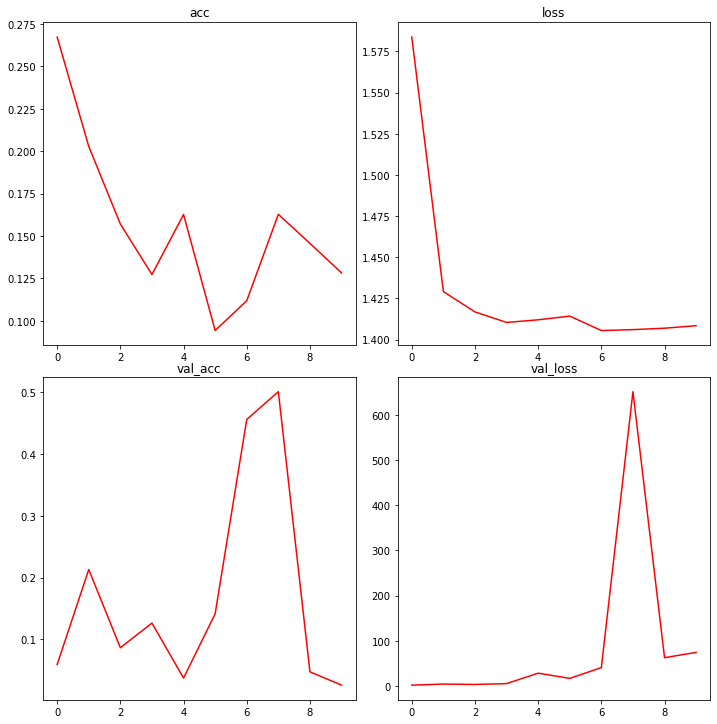

In [29]:
plt.figure(figsize=(3,4))
fig, axs = plt.subplots(2,2, figsize=(10,10))
plt.tight_layout()
axs[0,0].set_title('acc')
axs[0,0].plot(history.history['accuracy'], color='red')
axs[0,1].set_title('loss')
axs[0,1].plot(history.history['loss'], color='red')
axs[1,0].set_title('val_acc')
axs[1,0].plot(history.history['val_accuracy'], color='red')
axs[1,1].set_title('val_loss')
axs[1,1].plot(history.history['val_loss'], color='red')
plt.savefig("eval.png")